In [1]:
# import relevant packages
import numpy as np 
import torch
import matplotlib.pyplot as plt
from imageio import imread, imwrite
from torch import nn
import random
import argparse
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity
from steganogan import SteganoGAN
from steganogan.encoders import BasicEncoder
from steganogan.decoders import BasicDecoder
from steganogan.critics import BasicCritic

import torch
from torch.optim import LBFGS
import torch.nn.functional as F

# set seed
seed = 11111
np.random.seed(seed)
 
L1 = np.random.randn(3, 3)
print(L1)

np.random.seed(seed)
L2 = np.random.randn(3, 3)
print(L2)

torch.manual_seed(seed)

[[-0.07720066  1.24180298 -1.70285456]
 [-1.59426978 -3.01504378 -0.01902549]
 [-0.03201064 -0.48214818 -1.27554107]]
[[-0.07720066  1.24180298 -1.70285456]
 [-1.59426978 -3.01504378 -0.01902549]
 [-0.03201064 -0.48214818 -1.27554107]]


In [2]:
from math import log10
import cv2

def calc_psnr(img1, img2):
    ### args:
        # img1: [h, w, c], range [0, 255]
        # img2: [h, w, c], range [0, 255]
    diff = (img1 - img2) / 255.0
    diff[:,:,0] = diff[:,:,0] * 65.738 / 256.0
    diff[:,:,1] = diff[:,:,1] * 129.057 / 256.0
    diff[:,:,2] = diff[:,:,2] * 25.064 / 256.0

    diff = np.sum(diff, axis=2)
    mse = np.mean(np.power(diff, 2))
    return -10 * log10(mse)

def calc_ssim(img1, img2):
    def ssim(img1, img2):
        C1 = (0.01 * 255)**2
        C2 = (0.03 * 255)**2

        img1 = img1.astype(np.float64)
        img2 = img2.astype(np.float64)
        kernel = cv2.getGaussianKernel(11, 1.5)
        window = np.outer(kernel, kernel.transpose())

        mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
        mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
        mu1_sq = mu1**2
        mu2_sq = mu2**2
        mu1_mu2 = mu1 * mu2
        sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
        sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
        sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

        ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                                (sigma1_sq + sigma2_sq + C2))
        return ssim_map.mean()

    ### args:
        # img1: [h, w, c], range [0, 255]
        # img2: [h, w, c], range [0, 255]
        # the same outputs as MATLAB's
    border = 0
    img1_y = np.dot(img1, [65.738,129.057,25.064])/256.0+16.0
    img2_y = np.dot(img2, [65.738,129.057,25.064])/256.0+16.0
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    h, w = img1.shape[:2]
    img1_y = img1_y[border:h-border, border:w-border]
    img2_y = img2_y[border:h-border, border:w-border]
    img2_y = img2_y[border:h-border, border:w-border]

    if img1_y.ndim == 2:
        return ssim(img1_y, img2_y)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [3]:
def shuffle_params(m):
    if type(m)==nn.Conv2d or type(m)==nn.BatchNorm2d:
        param = m.weight
        m.weight.data = nn.Parameter(torch.tensor(np.random.normal(0, 1, param.shape)).float())

        param = m.bias
        m.bias.data = nn.Parameter(torch.zeros(len(param.view(-1))).float().reshape(param.shape))

In [4]:
idx = 801

num_bits = 2
steps = 2000
max_iter = 20
alpha = 0.1
eps = 0.305

criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

for seed in [11111,22222,33333,44444,55555,66666,777777,88888,99999,0]:
    np.random.seed(seed)
    model = BasicDecoder(num_bits, hidden_size=128)
    model.apply(shuffle_params)
    model.to('cuda')
    
    # image = f"/home/vk352/FaceDetection/datasets/div2k/val/512/{idx:04d}.jpg"
    image = f"./xxx_64.jpg"
    image = imread(image, pilmode='RGB') / 255.0
    image = torch.FloatTensor(image).permute(2, 1, 0).unsqueeze(0)
    image = image.to('cuda')
    out = model(image)
    
    torch.manual_seed(idx)
    target = torch.bernoulli(torch.empty(out.shape).uniform_(0, 1)).to(out.device)
    print(target.shape)
    eps = eps-0.005
    print("eps:", eps)
    adv_image = image.clone().detach().contiguous()
    
    for i in range(steps // max_iter):
        adv_image.requires_grad = True
        optimizer = LBFGS([adv_image], lr=alpha, max_iter=max_iter)

        def closure():
            outputs = model(adv_image)
            loss = criterion(outputs, target)

            optimizer.zero_grad()
            loss.backward()
            return loss

        optimizer.step(closure)
        delta = torch.clamp(adv_image - image, min=-eps, max=eps)
        adv_image = torch.clamp(image + delta, min=0, max=1).detach().contiguous()

        acc = len(torch.nonzero((model(adv_image)>0).float().view(-1) != target.view(-1))) / target.numel()
        print(i, acc)
        if acc==0: break
    print(seed)
    psnr = calc_psnr((image.squeeze().permute(2,1,0)*255).detach().cpu().numpy(), (adv_image.squeeze().permute(2,1,0)*255).detach().cpu().numpy())
    print("psnr:",psnr)
    print("ssim:",calc_ssim((image.squeeze().permute(2,1,0)*255).detach().cpu().numpy(), (adv_image.squeeze().permute(2,1,0)*255).detach().cpu().numpy()))
    print("error:", acc)
    lbfgsimg = (adv_image.cpu().squeeze().permute(2,1,0).numpy()*255).astype(np.uint8)
    if psnr>19: break

C:\Users\Jia\AppData\Local\Temp\ipykernel_15208\741104961.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(image, pilmode='RGB') / 255.0


torch.Size([1, 2, 64, 64])
eps: 0.3
0 0.324462890625
1 0.256591796875
2 0.1890869140625
3 0.1605224609375
4 0.1326904296875
5 0.1044921875
6 0.10205078125
7 0.081787109375
8 0.082275390625
9 0.0660400390625
10 0.064453125
11 0.054931640625
12 0.051025390625
13 0.048095703125
14 0.0460205078125
15 0.04345703125
16 0.0421142578125
17 0.0396728515625
18 0.0372314453125
19 0.0355224609375
20 0.0338134765625
21 0.0343017578125
22 0.0303955078125
23 0.0296630859375
24 0.03076171875
25 0.0279541015625
26 0.02587890625
27 0.0255126953125
28 0.0235595703125
29 0.022705078125
30 0.021240234375
31 0.0208740234375
32 0.019775390625
33 0.0206298828125
34 0.01708984375
35 0.02001953125
36 0.014892578125
37 0.017333984375
38 0.0140380859375
39 0.0169677734375
40 0.012939453125
41 0.0146484375
42 0.01123046875
43 0.014404296875
44 0.0108642578125
45 0.012939453125
46 0.009765625
47 0.01025390625
48 0.00830078125
49 0.010498046875
50 0.008056640625
51 0.0101318359375
52 0.0068359375
53 0.0093994140625


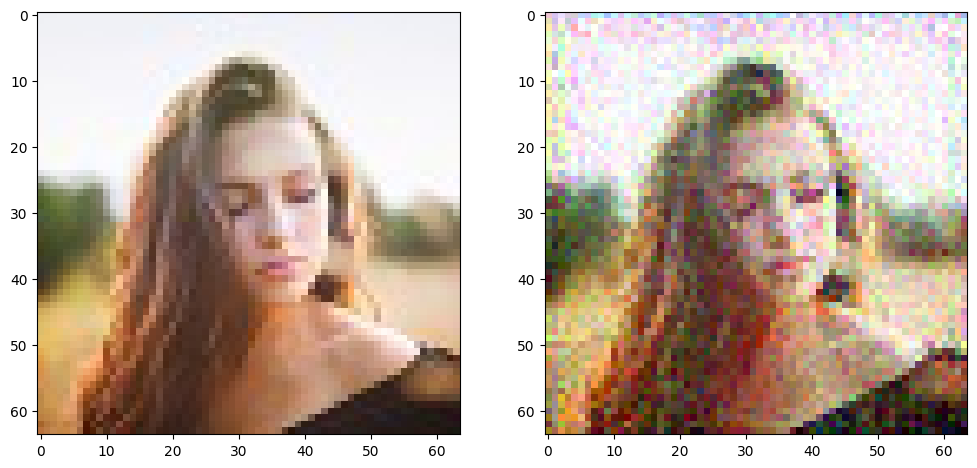

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow((image.squeeze().permute(2,1,0)*255).detach().cpu().numpy().astype(np.uint8))
ax[1].imshow((adv_image.squeeze().permute(2,1,0)*255).detach().cpu().numpy().astype(np.uint8))